# 04 - Classification with Neural Networks
In this section, we will assess the performance of various neural network models for classifying the offensiveness of a tweet. In particular, we will examine:
- Multilayer perceptron
- Convolutional neural network

Whereas Naive Bayes models learn and predict on some form of term frequency vectors, [neural networks](https://en.wikipedia.org/wiki/Artificial_neural_network) can use [word vector embeddings](https://www.tensorflow.org/tutorials/word2vec) in which each word is represented as a vector of pre-defined dimensionality. The key to the vector space model is that words with similar semantic meanings are also represented as similar vectors (as measured by some distance metric such as cosine similarity). There exist many methods to embedding the semantic meaning of a word, but they share in common the notion that a word's meaning can be defined by the totality of the contexts in which the word appears. In other words, a word's meaning is defined by its neighbors.

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

pd.options.display.max_colwidth = 400

%matplotlib inline

### Load data

In [6]:
data_path = os.path.join('..','data','dataframe_clean')
with open(data_path, 'rb') as file_in:
    df_clean = pkl.load(file_in)
    
df_clean.head(3)

,text,rating,confidence
id,,,
853718217,warning : penny board will make -PRON- a faggot,1,0.6013
853718218,fuck dyke,2,0.7227
853718219,twitter_handle twitter_handle twitter_handle twitter_handle twitter_handle at least i do not look like jefree starr faggot,2,0.5229


In [7]:
np.random.seed(1701)

from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Activation, Embedding, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping

# Building an embedding matrix
Previously, when using term frequency models, a tweet was represented as a single vector. However, if instead, words are represented as vectors, and a tweet is a collection of words, then a tweet is represented not as a vector but as a matrix where the $i^{th}$ row is the vector embedding of the $i^{th}$ word in the tweet. This matrix representation of a tweet provides a similarity to the classification of images that is especially useful when working with convolutional neural networks later.

The conversion of a tweet into a matrix involves two elements: an index sequence vector and an embedding matrix. In this model, given a vocabulary of size $v$, each term of the vocabulary is assigned a unique index value from $0$ to $v-1$. A tweet's index sequence vector, then, is a vector in which its $i^{th}$ element is the index value of the $i^{th}$ word in the tweet.

An embedding matrix of size $v \times d$, where $d$ is a pre-specified dimensionality of the word vector embeddings, is a matrix in which the $n^{th}$ row is the $d$-dimensional vector embedding of the term corresponding to index value $n$. Thus, with an index sequence vector, we can select which rows of the embedding matrix to use to build a tweet's representational matrix.

Given our corpus of 13,000 tweets and vocabulary of 16,500, a 100-dimensional vector embedding is sufficient (prior tests showed that 100-dimensional embeddings outperformed 50 and 200-dimensional embeddings). We remove from the vocabulary all words that appear only once in the corpus since one set of neighbors does not seem to be enough to discern a word's meaning. Excluding all terms that appear in the corpus once leaves over 7,000 terms, much higher than the 261 terms used by Bernoulli Naive Bayes for classification.

Below, we train a Word2Vec model to learn the vector embeddings of the 7,000 terms.

In [68]:
load_pretrained = False

# create 100-dimensional vector embeddings for words that appear in the corpus at least 2 times
embedding_dimension = 100

if load_pretrained:
    with open('../data/word2vec_model_local', 'rb') as file_in:
        model = pkl.load(file_in)
else:
    model = Word2Vec([tweet.split() for tweet in df_clean.text], min_count = 2, size = embedding_dimension,
                     window = 10, sg = 1)
    with open('../data/word2vec_model_local', 'wb') as file_out:
        pkl.dump(model, file_out)
        
max_vocab_size = len(model.wv.vocab)
print('word2vec vocabulary size:', max_vocab_size)

# tokenize each tweet in the corpus. this will be useful for embedding each tweet as an index sequence vector
tokenizer = Tokenizer(num_words = max_vocab_size)
tokenizer.fit_on_texts(df_clean.text)
print('tokenizer vocabulary size:', tokenizer.num_words)

word2vec vocabulary size: 6252
tokenizer vocabulary size: 6252


A quick check of the most related terms to "trump" shows that the embeddings at least make sense semantically.

In [69]:
# check quality of word vector embedding
model.most_similar(['trump'])

[('muslim', 0.9723699688911438),
 ('religion', 0.9563922882080078),
 ('islam', 0.9508674740791321),
 ('isis', 0.9348325729370117),
 ('race', 0.9341102838516235),
 ('anti', 0.9298616647720337),
 ('donald', 0.9288190007209778),
 ('america', 0.9256894588470459),
 ('country', 0.9203171730041504),
 ('rape', 0.9191108345985413)]

Here, we construct an embedding matrix out of the trained vectors.

In [70]:
# create embedding matrix where each row corresponds to a vector for a word. the row index is determined by tokenizer.
embedding_matrix = np.zeros([max_vocab_size + 1, embedding_dimension])
for word, index in tokenizer.word_index.items():
    if word in model.wv.vocab:
        vector = model[word]
        embedding_matrix[index,:] = vector

print('number of words without vector embeddings:', sum(embedding_matrix.sum(axis = 1) == 0))

number of words without vector embeddings: 159


Because non-recurrent neural networks expect inputs of the same dimensions, we pad all index sequence vectors with zeros until they are the same length as the longest index sequence vector. The actual process of using an embedding matrix to convert an index sequence vector into a word matrix is a step within the Keras' neural network implementation itself.

In [71]:
# convert tweets to index sequence vectors
X = tokenizer.texts_to_sequences(df_clean.text)
max_sequence_length = np.array([len(sequence) for sequence in X]).max()
print('The tweet with the longest sequence has {} indices.'.format(max_sequence_length))

# pad index sequence vectors so they all have same length and X is rectangular
X = pad_sequences(X, maxlen = max_sequence_length, padding = 'post', truncating = 'post')
print('Matrix X has shape:', X.shape)

# create label matrix y
y = to_categorical(df_clean.rating)
print('Labels y has shape:', y.shape)

The tweet with the longest sequence has 35 indices.
Matrix X has shape: (13111, 35)
Labels y has shape: (13111, 3)


### Save processed data for later analysis

In [136]:
with open('../data/data_nn', 'wb') as file_out:
    pkl.dump([X, y], file_out)  

### Create train-test split

In [73]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 1)

# Multilayer perceptron
We begin with a "vanilla" neural network to set a baseline with which to measure the more sophisticated models against. Many different topologies were tested, but ultimately, the optimal network was a rather small one, with only two hidden layers consisting of 75 and 20 nodes. Even with such a small architecture, the network severely overfits the training data, producing training accuracies of around 0.9 against cross-validated accuracies of 0.75.

To combat this, a regularization technique called [dropout](http://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/) is applied in which for each learning pass, the network de-activates a randomly selected proportion of neurons so that they do not contribute information to downstream neurons during the feedforward phase and their associated weights are not updated during the backpropagation phase. The technique is elegant in that it has the effect of emulating an ensemble method where several smaller networks are trained and averaged together.

In [126]:
mlp = Sequential()
mlp.add(Embedding(embedding_matrix.shape[0],
                 embedding_matrix.shape[1],
                 weights = [embedding_matrix],
                 input_shape = (X.shape[1],)))
mlp.add(Flatten())
mlp.add(Dense(75, activation = 'relu'))
mlp.add(Dropout(0.75))
mlp.add(Dense(20, activation = 'relu'))
mlp.add(Dropout(0.75))
mlp.add(Dense(3, activation = 'softmax'))
mlp.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [127]:
early_stopping = EarlyStopping(patience = 2, monitor = 'val_acc')
history = mlp.fit(X_train, y_train, validation_split = 0.3, epochs = 30, callbacks = [early_stopping],
                  batch_size = 200, verbose = False)

Notably, it takes a rather high dropout rate of 0.75 to reasonably control the network's tendency to overfit, but the improvement in cross-validated accuracy is notable, increasing to 0.783. In fact, even a network with as small as a 30-to-10 node topology tends to overfit while producing cross-validated accuracies of 0.73. In much the same way the optimized Naive Bayes models only needed to consider a few hundred terms out of the entire vocabulary, the network may be focusing a small set of terms.

training accuracy: 0.790596292942
validation accuracy: 0.782861292579


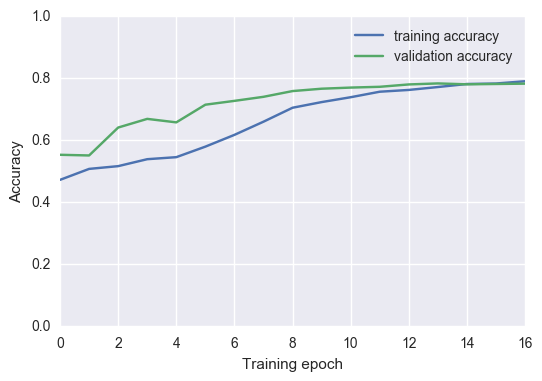

In [128]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(train_acc, label = 'training accuracy')
plt.plot(val_acc, label = 'validation accuracy')
plt.xlabel('Training epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 0)
plt.ylim(0,1)
print('training accuracy:', train_acc[-1])
print('validation accuracy:', val_acc[-1])

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

def proba_to_prediction(predict_probas):
    predictions = np.array([np.argmax(row) for row in predict_probas])
    return predictions

def evaluate(y, y_pred):
    print('Accuracy:', accuracy_score(y, y_pred))
    print('F1 weighted: ', f1_score(y, y_pred, average = 'weighted'))
    
    matrix = confusion_matrix(y, y_pred)
    matrix = matrix / matrix.sum().sum()
    print('Normalized confusion matrix:\n', matrix)
    
    y_values = pd.Series(y).value_counts()
    y_values = y_values / y_values.sum()
    print('Actual proportions:\n', np.array(y_values))
    
def flatten(y):
    y_cat = y.copy()
    y_cat[:,0] = 0
    y_cat[:,2] = y_cat[:,2] * 2
    y_cat = y_cat.sum(axis = 1)
    return y_cat

Unlike Naive Bayes models, neural networks can learn non-linear decision boundaries, which may explain why MLP has a slightly better accuracy than Bernoulli Naive Bayes (.781 to .776). However, the MLP's weighted F1-score is much lower because it failed to make a classification for hate speech.

In [132]:
predict_probas_mlp = mlp.predict(X_test)
y_test_pred_mlp = proba_to_prediction(predict_probas_mlp).reshape(-1)
y_test_flatten = flatten(y_test).reshape(-1)
evaluate(y_test_flatten, y_test_pred_mlp)

Accuracy: 0.780884595831
F1 weighted:  0.721340046358
Normalized confusion matrix:
 [[ 0.48754448  0.0264362   0.        ]
 [ 0.03889171  0.29334011  0.        ]
 [ 0.01499746  0.13879004  0.        ]]
Actual proportions:
 [ 0.51398068  0.33223183  0.15378749]


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


A potential reason for the absence of hate speech identification is that the MLP is actually handicapped by the choice of tweet representation model. Recall that when tweets were represented as term frequency vectors for Naive Bayes classification, the models trained and predicted a tweet rating only on the basis of the presence or multiplicity of terms in the tweet. In other words, it did not matter where the term occurs in the tweet, only that it did occur some number of times. When using a matrix of vector embeddings to represent the tweet instead, the position in which terms occur within a tweet become part of the model, so for example, "apples and oranges" and "oranges and apples" are converted into different vectors.

This lack of translational invariance could mean that under this representational model, the MLP would require more samples of hate speech than what is currently available to learn how to identify it. Using image classification to illustrate this issue, imagine an MLP designed to distinguish circles from other shapes. If we only gave it as positive samples images with circles in the upper left hand corner, the model would not be able to identify a circle located in any of the other corners. Similarly, if we provided the model as positive samples only four images of a circle each placed in a different corner, the model would likely not be able to identify a circle at all.

Now consider three hypothetical hate speech tweets where ------ represents an epithet:

1. ------ fuck you
2. ------ you fuck
3. fuck you ------

Using a term frequency model, the three tweets would be identical, so the classifier has essentially three training samples with which to learn that any permutation of "------", "fuck", and "you" should be considered hate speech. However, with a matrix embedding model, the same three tweets would convert to different matrices, like circles in different corners of an image, and the classifier may not learn that any of them much less a new permutation should be considered hate speech.

### Two-class performance evaluation
Because the MLP attained a high accuracy despite making no hate speech classifications, its accuracy and F1-scores are improved more than the Naive Bayes models when combining offensive and hate speech into one category.

In [133]:
y_binary = (y_test_flatten == 1) | (y_test_flatten == 2)
y_pred_binary = (y_test_pred_mlp == 1) | (y_test_pred_mlp == 2)
evaluate(y_binary, y_pred_binary)

Accuracy: 0.919674631418
F1 weighted:  0.919552056976
Normalized confusion matrix:
 [[ 0.48754448  0.0264362 ]
 [ 0.05388917  0.43213015]]
Actual proportions:
 [ 0.51398068  0.48601932]


### Save model for later analysis

In [134]:
mlp.save('../data/model_mlp')

# Convolutional Neural Network
[Convolutional neural networks](http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/) were originally developed to address the issues of translational and scaling variance in image classification problems. In a traditional CNN, two-dimensional convolutional filters (the kernels of which are learned through training) scan the image to detect the presence of salient features, and the results of such scans are pooled and fed forward through the network. Because the second dimension of a tweet embedding matrix holds no particular meaning, we use one-dimensional convolutional filters instead.

The topology of the optimal CNN for tweet classification is extremely small, consisting of only one convolutional layer, a *global* max pooling layer (which is typical for NLP), and no additional hidden layers, and even this network tends to significantly overfit. Some light dropout regularization is applied to the network, though previous tests revealed that fully controlling overfitting tended to hurt validation accuracy.

In [45]:
predict_probas_mlp = mlp.predict(X_test)
y_test_pred_mlp = proba_to_prediction(predict_probas_mlp).reshape(-1)
y_test_flatten = flatten(y_test).reshape(-1)
evaluate(y_test_flatten, y_test_pred_mlp)

Accuracy: 0.778596847992
F1 weighted:  0.717970249555
Normalized confusion matrix:
 [[ 0.49339095  0.02058973  0.        ]
 [ 0.04702593  0.2852059   0.        ]
 [ 0.01703101  0.13675648  0.        ]]
Actual proportions:
 [ 0.51398068  0.33223183  0.15378749]


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [120]:
cnn = Sequential()
cnn.add(Embedding(embedding_matrix.shape[0],
                 embedding_matrix.shape[1],
                 weights = [embedding_matrix],
                 input_shape = (X.shape[1],)))
# convolutional layer consisting of 40 filters with windows of size 5 and stride 1
cnn.add(Conv1D(40, 5, padding = 'valid', strides = 1, activation = 'relu'))
cnn.add(Dropout(0.4))
# global max pooling reduces a convolutional filter's entire output to a single max value, producing a 20-node
# ...hidden layer
cnn.add(GlobalMaxPooling1D()) 
cnn.add(Dropout(0.4))
cnn.add(Dense(3, activation = 'softmax'))
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [121]:
early_stopping = EarlyStopping(patience = 2, monitor = 'val_acc')
history = cnn.fit(X_train, y_train, validation_split = 0.3, epochs = 30, callbacks = [early_stopping],
                  batch_size = 200, verbose = False)

training accuracy: 0.934765686123
validation accuracy: 0.816267249804


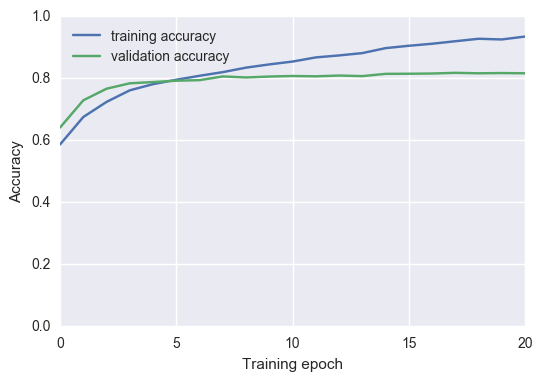

In [122]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(train_acc, label = 'training accuracy')
plt.plot(val_acc, label = 'validation accuracy')
plt.legend(loc = 0)
plt.xlabel('Training epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
print('training accuracy:', train_acc[-1])
print('validation accuracy:', val_acc[-1])

As expected, with a test accuracy of 0.826 and F1-score of 0.82, the CNN outperforms all previous models despite overfitting on training data. The overfitting is permitted because, oddly, a less powerful CNN does not learn to identify hate speech. But by allowing the model to overfit, it is able to even correctly classify hate speech on held-out test data.

In [123]:
predict_probas = cnn.predict(X_test)
y_pred = proba_to_prediction(predict_probas).reshape(-1)
y_test_flatten = flatten(y_test).reshape(-1)
evaluate(y_test_flatten, y_pred)

Accuracy: 0.826131164209
F1 weighted:  0.821640757788
Normalized confusion matrix:
 [[ 0.49084901  0.01931876  0.00381291]
 [ 0.02846975  0.25749873  0.04626335]
 [ 0.01474326  0.0612608   0.07778343]]
Actual proportions:
 [ 0.51398068  0.33223183  0.15378749]


### Two-class performance evaluation

In [124]:
y_binary = (y_test_flatten == 1) | (y_test_flatten == 2)
y_pred_binary = (y_pred == 1) | (y_pred == 2)
evaluate(y_binary, y_pred_binary)

Accuracy: 0.933655312659
F1 weighted:  0.93359115775
Normalized confusion matrix:
 [[ 0.49084901  0.02313167]
 [ 0.04321301  0.4428063 ]]
Actual proportions:
 [ 0.51398068  0.48601932]


### Save model for later analysis

In [137]:
cnn.save('../data/model_cnn')

# Test original tweets

In [164]:
def tweet_rater(tweet):
    tweet = clean_tweet(tweet)
    tweet_tokens = [token.lemma_ for token in nlp(tweet)]
    tweet = ' '.join(tweet_tokens)
    print(tweet)
    x_vect = tokenizer.texts_to_sequences([tweet])
    x_vect = pad_sequences(x_vect, maxlen = max_sequence_length, padding = 'post', truncating = 'post')
    probas = cnn.predict(x_vect)[0]
    print(probas)
    rating = np.argmax(probas)
    if rating == 0:
        print('I\'m {:2.4}% sure that\'s not offensive.'.format(probas[0]*100))
    elif rating == 1:
        print('I\'m {:2.4}% sure that\'s offensive.'.format(probas[1]*100))
    else:
        print('I\'m {:2.4}% sure that\'s hate speech.'.format(probas[2]*100))

In [165]:
tweet_rater('you\'re an idiot')

-PRON- be an idiot
[ 0.28718743  0.50503135  0.20778121]
I'm 50.5% sure that's offensive.
